# Importing the relevant libraries

In [25]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

%matplotlib inline

from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import statsmodels.api as sm
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix




# Data Preprocessing

### Importing the Database

In [3]:
# Load CSV file 
raw_data = pd.read_csv("ml_datasource.csv")

# Display the first 5 rows 
raw_data.head()


,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,2,15.81,0
1,SG,260,1.7,1,1,0,16.00,0
2,TR,260,22.4,1,1,0,0.93,0
3,KE,259,18.8,1,1,1,14.63,0
4,IN,259,118.0,2,2,1,16.48,0


In [4]:
# Create a copy 
data = raw_data.copy()
print(data.shape)

(17761, 8)


### Removing Outliers

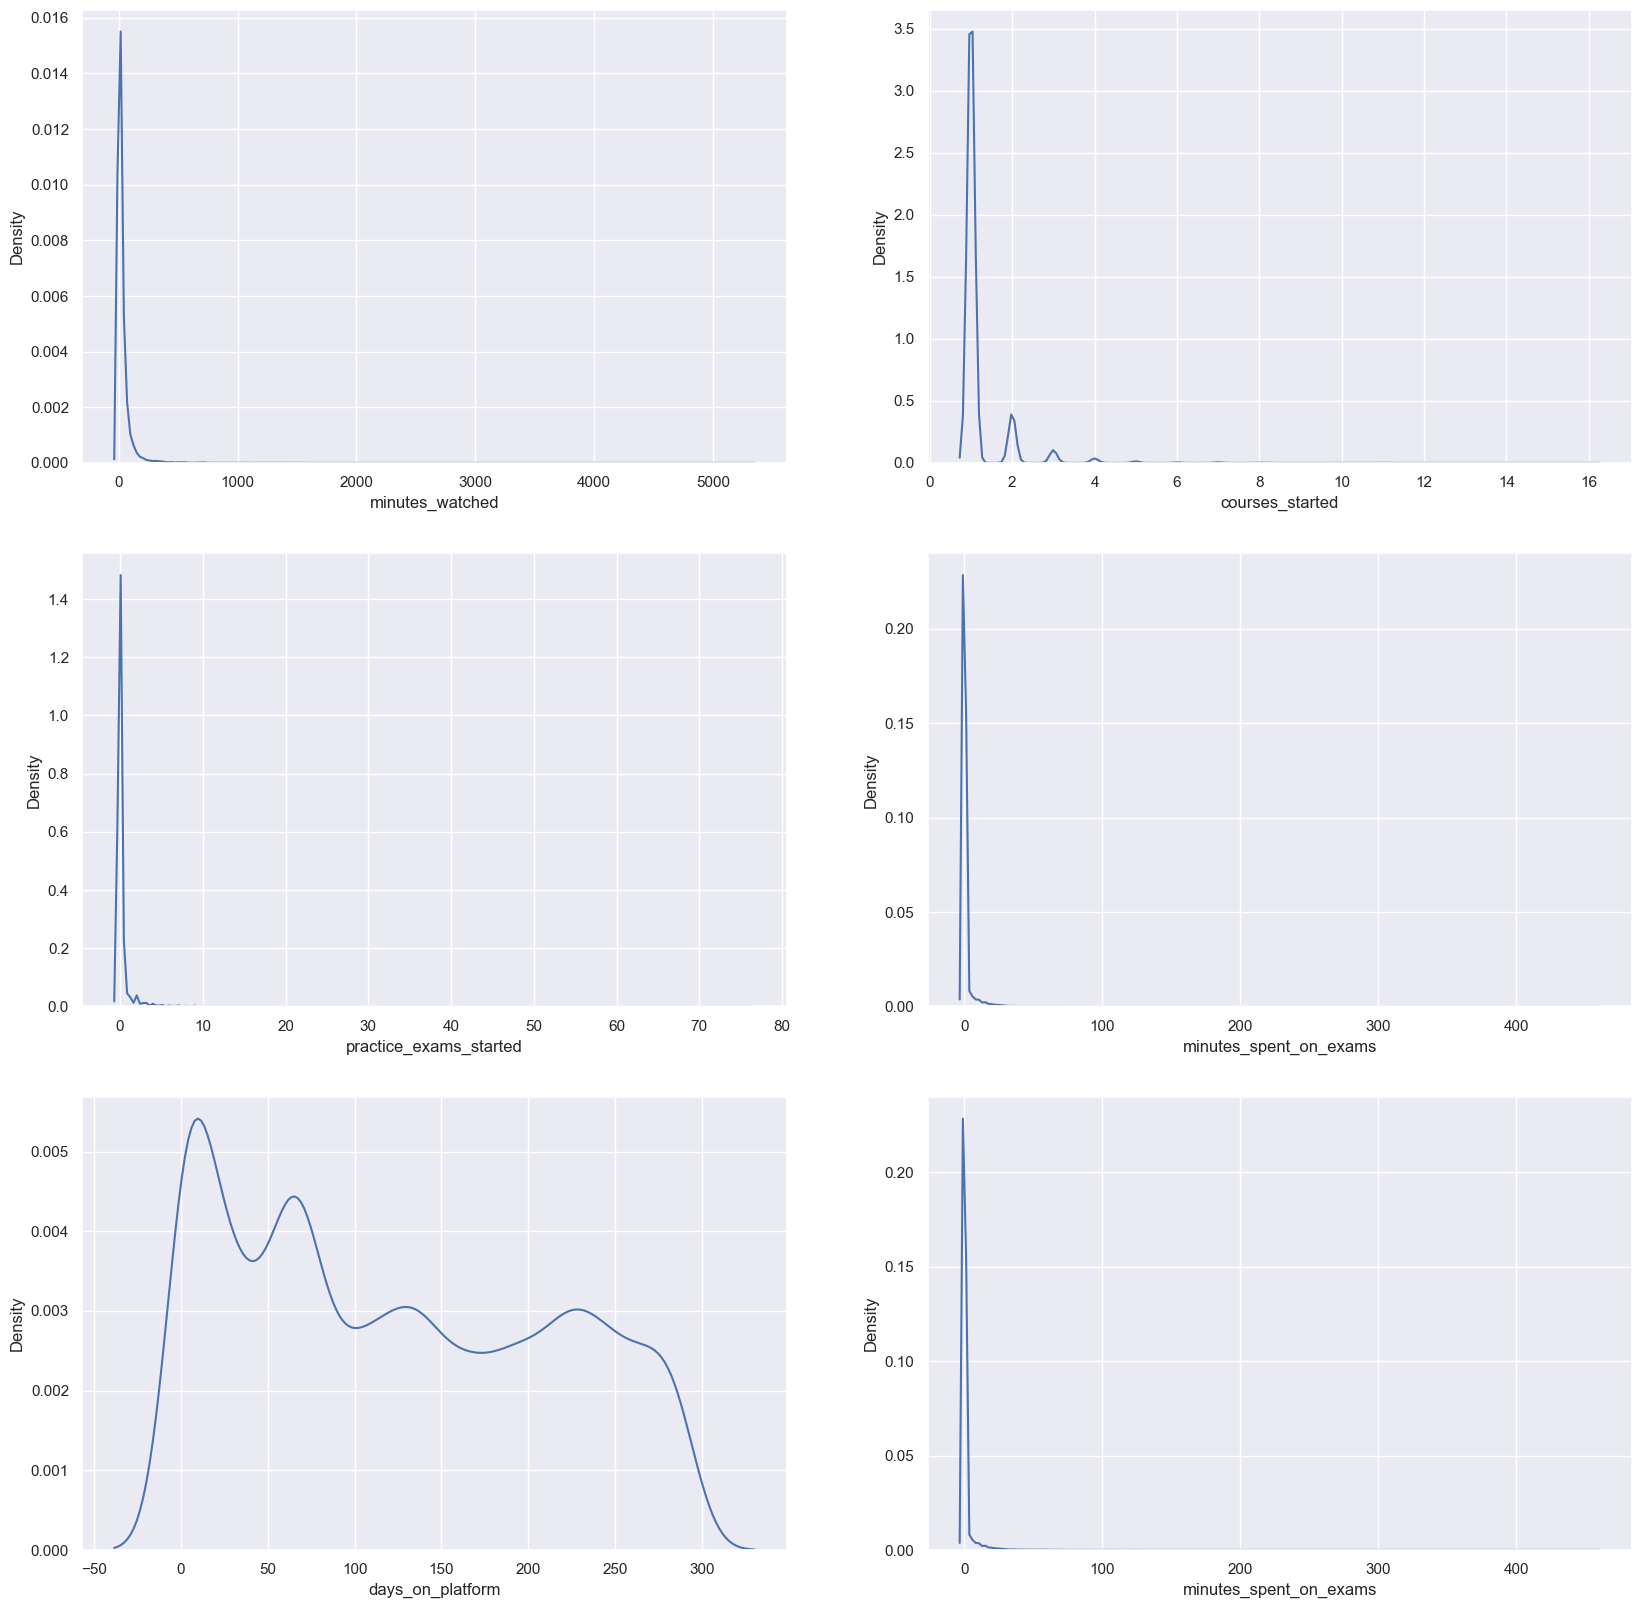

In [5]:
#Plotting distributions BEFORE removing outliers

# Set Seaborn theme
sns.set()

fig, axes = plt.subplots(3, 2, figsize=(20, 20))

sns.kdeplot(data=data['minutes_watched'], ax=axes[0, 0])
#axes[0, 0 ].set_title("Minutes Watched")

sns.kdeplot(data=data['courses_started'], ax=axes[0, 1])
#axes[0, 1 ].set_title("Courses Started")

sns.kdeplot(data=data['practice_exams_started'], ax=axes[1, 0])
#axes[1, 0 ].set_title("Practice Exams Started")

sns.kdeplot(data=data['minutes_spent_on_exams'], ax=axes[1, 1])
#axes[1, 1 ].set_title("Minutes Spent On Exams")


sns.kdeplot(data=data['days_on_platform'], ax=axes[2, 0])
#axes[2, 0 ].set_title("Days On Platform")

sns.kdeplot(data=data['minutes_spent_on_exams'], ax=axes[2, 1])
#axes[2, 1 ].set_title("Minutes Spent On Exams")


plt.show()


In [6]:
#Removing outliers
data_no_outliers = data[
(data['minutes_watched'] <= 1000) &
(data['courses_started'] <=10)&
(data['practice_exams_started'] <=10) &
(data['minutes_spent_on_exams'] <=40)].copy()

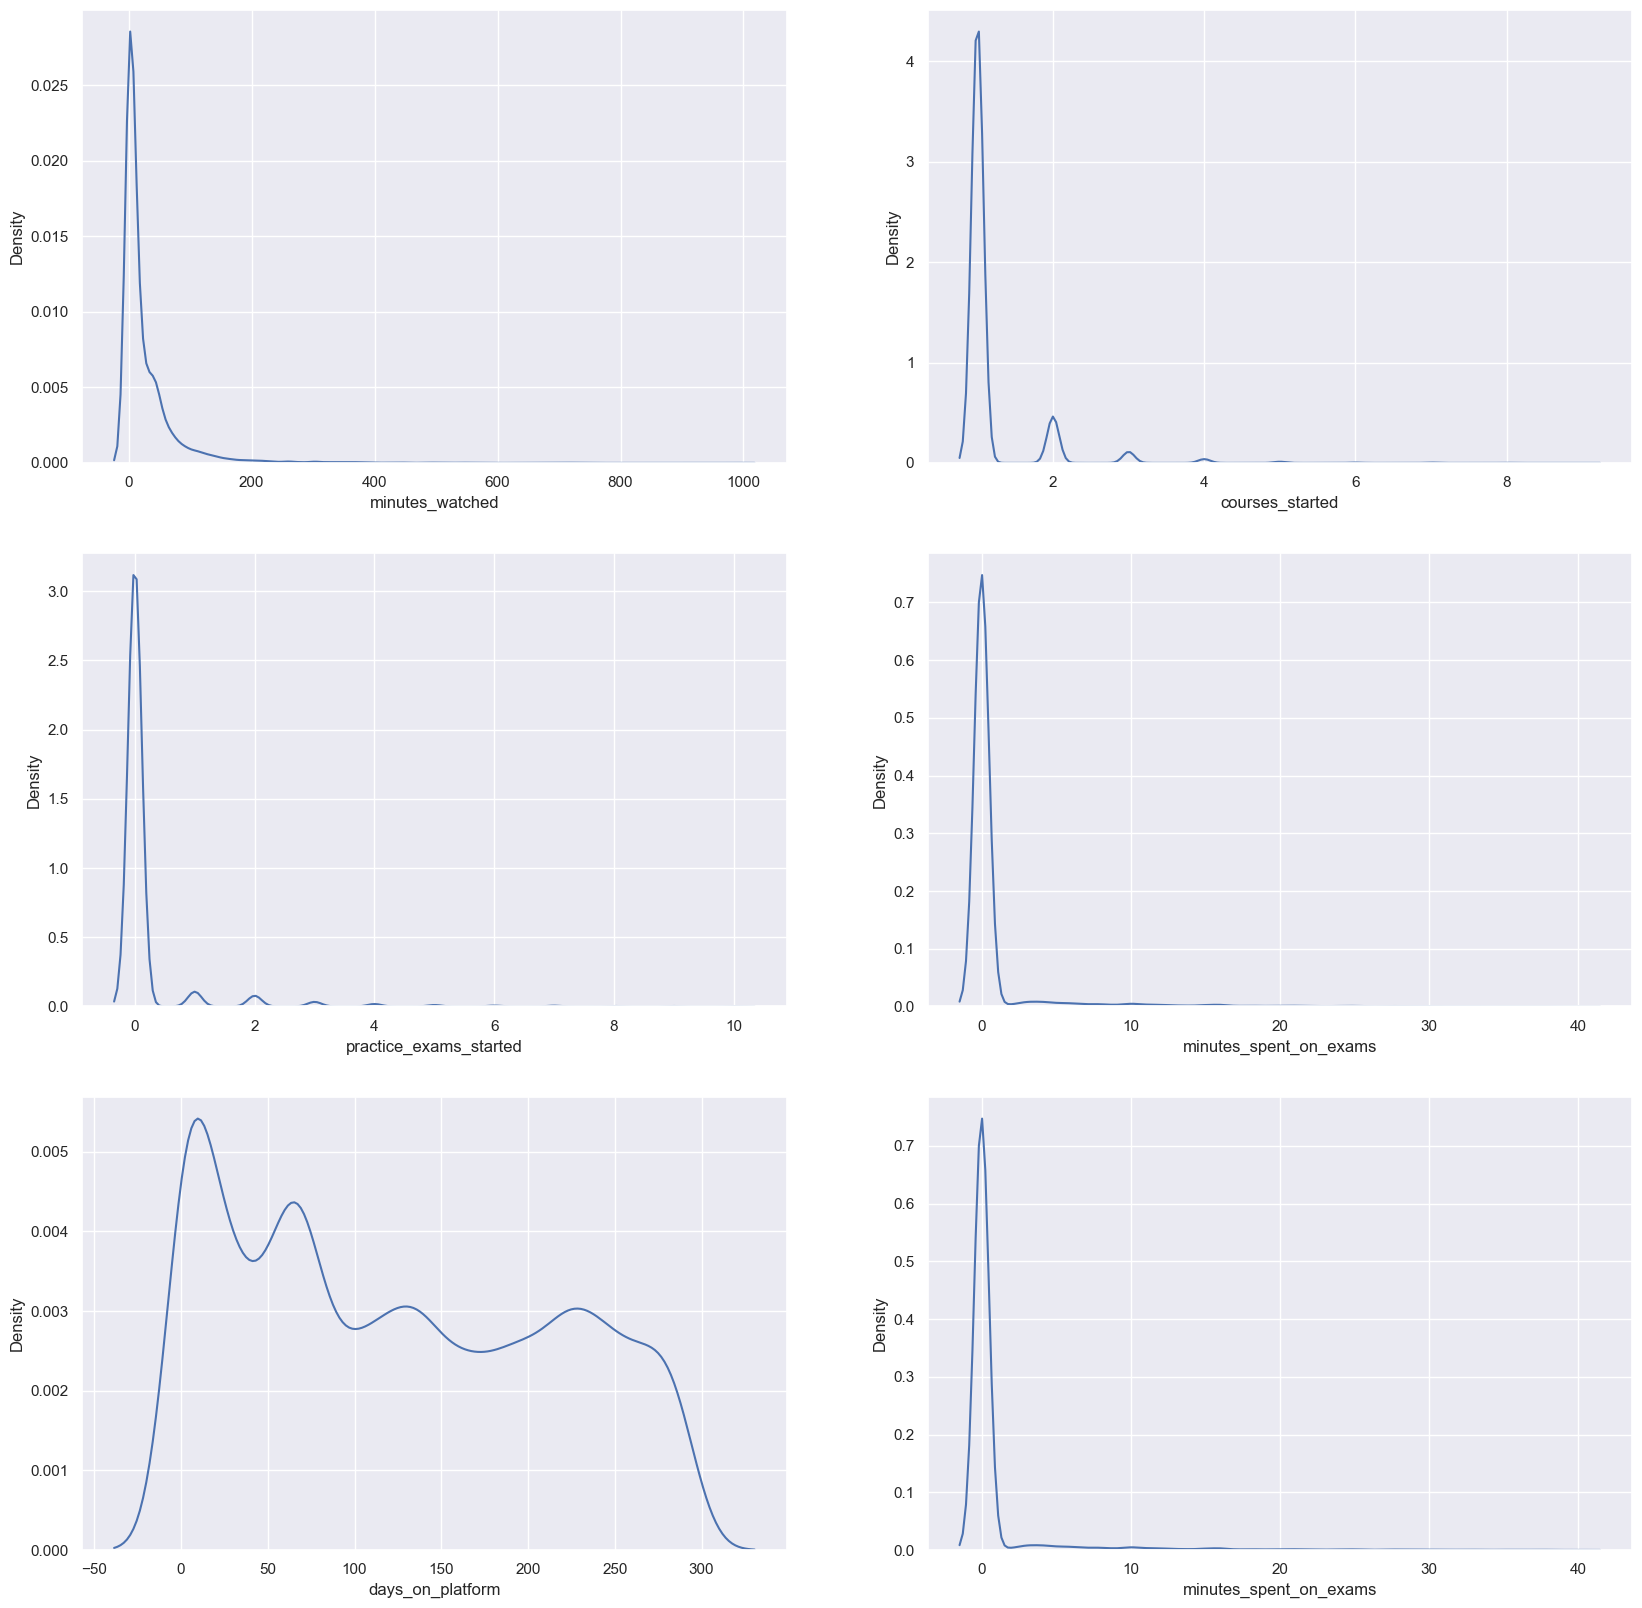

In [7]:

#Plotting distributions AFTER removing outliers
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

sns.kdeplot(data=data_no_outliers['minutes_watched'], ax=axes[0, 0])
#axes[0, 0 ].set_title("Minutes Watched")

sns.kdeplot(data=data_no_outliers['courses_started'], ax=axes[0, 1])
#axes[0, 1 ].set_title("Courses Started")

sns.kdeplot(data=data_no_outliers['practice_exams_started'], ax=axes[1, 0])
#axes[1, 0 ].set_title("Practice Exams Started")

sns.kdeplot(data=data_no_outliers['minutes_spent_on_exams'], ax=axes[1, 1])
#axes[1, 1 ].set_title("Minutes Spent On Exams")


sns.kdeplot(data=data_no_outliers['days_on_platform'], ax=axes[2, 0])
#axes[2, 0 ].set_title("Days On Platform")

sns.kdeplot(data=data_no_outliers['minutes_spent_on_exams'], ax=axes[2, 1])
#axes[2, 1 ].set_title("Minutes Spent On Exams")


plt.show()


### Checking for Multicollinearity

In [11]:
#Import and Data Preparation
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Copy the dataset after removing outliers
df = data_no_outliers.copy()

# Select numeric columns only
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols.remove('purchased')

print("Selected numeric columns:", numeric_cols)

Selected numeric columns: ['days_on_platform', 'minutes_watched', 'courses_started', 'practice_exams_started', 'practice_exams_passed', 'minutes_spent_on_exams']


In [12]:
#Define the VIF Function
def calculate_vif(data, features):
    """
    Calculate Variance Inflation Factor (VIF) for each feature.
    """
    vif_data = pd.DataFrame()
    vif_data['Feature'] = features
    vif_data['VIF'] = [variance_inflation_factor(data[features].values, i) for i in range(len(features))]
    return vif_data


In [13]:
#Loop to Remove Features with VIF > 5
features = numeric_cols.copy()
iteration = 1

while True:
    print(f"\nIteration {iteration}:")
    vif_df = calculate_vif(df, features)
    print(vif_df)

    max_vif = vif_df['VIF'].max()
    if max_vif <= 5:
        break

    feature_to_drop = vif_df.sort_values('VIF', ascending=False)['Feature'].iloc[0]
    print(f"Removing '{feature_to_drop}' with VIF={max_vif:.2f}")
    features.remove(feature_to_drop)
    
    iteration += 1



Iteration 1:
                  Feature        VIF
0        days_on_platform   2.301237
1         minutes_watched   1.788777
2         courses_started   3.178713
3  practice_exams_started  10.201823
4   practice_exams_passed   7.812546
5  minutes_spent_on_exams   3.345478
Removing 'practice_exams_started' with VIF=10.20

Iteration 2:
                  Feature       VIF
0        days_on_platform  2.299940
1         minutes_watched  1.788276
2         courses_started  3.174319
3   practice_exams_passed  2.562412
4  minutes_spent_on_exams  2.602966


In [14]:
#Final Dataset After Removing Multicollinear Features

data_no_mult = df[features + ['purchased']].copy()
print("\nFinal dataset columns:", data_no_mult.columns.tolist())



Final dataset columns: ['days_on_platform', 'minutes_watched', 'courses_started', 'practice_exams_passed', 'minutes_spent_on_exams', 'purchased']


### Dealing with NaN Values

In [15]:
#Copy the dataset for cleaning
df = data_no_outliers.copy()

In [16]:
#Check for missing values
print("NaN values per column before cleaning:")
print(df.isnull().sum())

print("\nRows where 'student_country' is NaN:")
print(df[df['student_country'].isna()])


NaN values per column before cleaning:
student_country           8
days_on_platform          0
minutes_watched           0
courses_started           0
practice_exams_started    0
practice_exams_passed     0
minutes_spent_on_exams    0
purchased                 0
dtype: int64

Rows where 'student_country' is NaN:
      student_country  days_on_platform  minutes_watched  courses_started  \
311               NaN                88             58.1                1   
337               NaN                86             43.0                1   
556               NaN               121            241.9                2   
806               NaN                64             86.4                1   
1097              NaN                72             67.5                1   
12363             NaN                84              6.2                1   
12633             NaN                78              3.0                1   
16946             NaN                11              8.2              

In [17]:
#Fill missing values
# Fill NaN values for 'student_country' with 'NAM'
data_no_nulls = df.fillna(value={'student_country': 'NAM'})


In [18]:
#Verify missing values have been filled
print("NaN values per column after cleaning:")
print(data_no_nulls.isnull().sum())


NaN values per column after cleaning:
student_country           0
days_on_platform          0
minutes_watched           0
courses_started           0
practice_exams_started    0
practice_exams_passed     0
minutes_spent_on_exams    0
purchased                 0
dtype: int64


### Splitting the Data

In [19]:
#  Separate inputs and target

X = data_no_nulls.drop('purchased', axis=1)
y= data_no_nulls['purchased']


In [20]:
#  Split the data

x_train, x_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=365,
    stratify=y)

In [21]:
# Verification

print("Taille X train :", x_train.shape)
print("Taille X test  :", x_test.shape)
print("Distribution y :", y.value_counts(normalize=True))
print("Distribution y_train :", y_train.value_counts(normalize=True))
print("Distribution y_test :", y_test.value_counts(normalize=True))


Taille X train : (14100, 7)
Taille X test  : (3526, 7)
Distribution y : purchased
0    0.907863
1    0.092137
Name: proportion, dtype: float64
Distribution y_train : purchased
0    0.907872
1    0.092128
Name: proportion, dtype: float64
Distribution y_test : purchased
0    0.907828
1    0.092172
Name: proportion, dtype: float64


### Encoding the Data

In [22]:
# Initializing an ordinal encoder for categorical variables
enc = OrdinalEncoder(handle_unknown = 'use_encoded_value', 
                     unknown_value = 170);

In [23]:
# Encoding the 'student_country' column in the training and testing datasets
# and storing the encoded variable in a new column called 'student_country_enc'
x_train['student_country_enc'] = enc.fit_transform(x_train['student_country'].to_numpy().reshape(-1, 1));
x_test['student_country_enc'] = enc.transform(x_test['student_country'].to_numpy().reshape(-1, 1));

# Dropping the original 'student_country' column after encoding
x_train = x_train.drop('student_country', axis = 1)
x_test = x_test.drop('student_country', axis = 1)

# Displaying the first five rows of the encoded training dataset
x_train.head()

,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,student_country_enc
5718,218,1.6,2,0,0,0.0,69.0
3119,263,75.5,1,0,0,0.0,69.0
5440,222,44.4,1,0,0,0.0,84.0
11828,97,2.6,1,0,0,0.0,148.0
8454,162,1.0,1,0,0,0.0,80.0


In [24]:
# We use the np.asarray() method to ensure data type consistency and compatibility.
# y_train values are converted to integers and x_train values are converted to floating-point numbers.

x_train_array = np.asarray(x_train, dtype = 'float')
y_train_array = np.asarray(y_train, dtype = 'int')

x_test_array = np.asarray(x_test, dtype = 'float')
y_test_array = np.asarray(y_test, dtype = 'int')

# Creating a Logistic Regression Model

In [26]:
#Add a Constant for Statsmodels
x_train_sm = sm.add_constant(x_train_array)
x_test_sm = sm.add_constant(x_test_array)

In [27]:
#Create the Logistic Regression Model
log_reg = sm.Logit(y_train_array, x_train_sm)

In [28]:
#Train the Model
log_reg_results = log_reg.fit()

Optimization terminated successfully.
         Current function value: 0.149665
         Iterations 10


In [29]:
#Display the Model Summary
print(log_reg_results.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                14100
Model:                          Logit   Df Residuals:                    14092
Method:                           MLE   Df Model:                            7
Date:                Thu, 04 Dec 2025   Pseudo R-squ.:                  0.5132
Time:                        12:22:14   Log-Likelihood:                -2110.3
converged:                       True   LL-Null:                       -4334.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0554      0.118     -8.935      0.000      -1.287      -0.824
x1            -0.0667      0.002    -30.543      0.000      -0.071      -0.062
x2             0.0130      0.001     17.869      0.0

In [30]:
#Make Predictions on the Test Set
# Predict probabilities on the test set
y_pred_prob = log_reg_results.predict(x_test_sm)

# Convert probabilities to class labels (threshold = 0.5)
y_pred_class = (y_pred_prob > 0.5).astype(int)

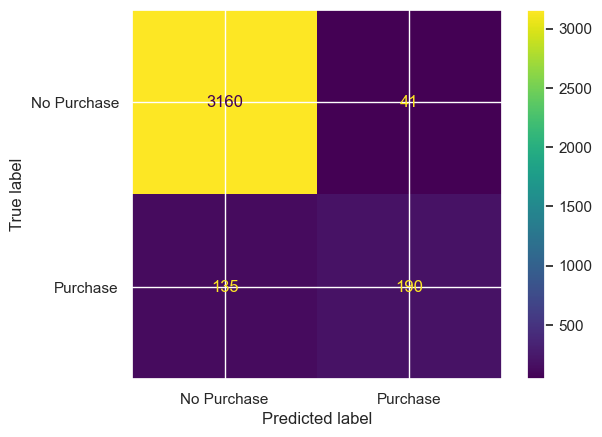

In [31]:
#Confusion Matrix
cm = confusion_matrix(y_test_array, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Purchase", "Purchase"])
disp.plot()
plt.show()

# Creating a K-Nearest Neighbors Model

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [ ]:
#Create a Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),       
    ('knn', KNeighborsClassifier())     
])

In [37]:
#Define Hyperparameter Grid
param_grid = {
    'knn__n_neighbors': range(1, 31),          
    'knn__weights': ['uniform', 'distance'],   
    'knn__metric': ['euclidean', 'manhattan']  
}

In [ ]:
#Set Up GridSearchCV
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                 
    scoring='accuracy',   
    n_jobs=-1             
)


In [39]:
#Train the Model
grid.fit(x_train_array, y_train_array)

,estimator,Pipeline(step...lassifier())])
,param_grid,"{'knn__metric': ['euclidean', 'manhattan'], 'knn__n_neighbors': range(1, 31), 'knn__weights': ['uniform', 'distance']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [40]:
#Display Best Parameters and Accuracy
print("Best hyperparameters found:")
print(grid.best_params_)

print("\n Best cross-validation accuracy:")
print(grid.best_score_)


Best hyperparameters found:
{'knn__metric': 'manhattan', 'knn__n_neighbors': 18, 'knn__weights': 'distance'}

 Best cross-validation accuracy:
0.9556737588652483


In [41]:
#Make Predictions on Test Set
y_pred_knn = grid.predict(x_test_array)


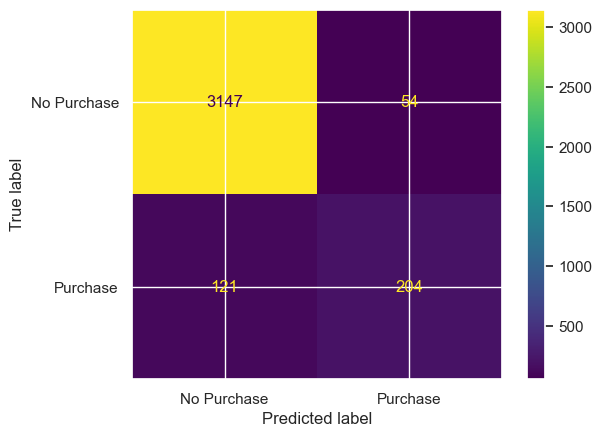

In [42]:
#Confusion Matrix
cm = confusion_matrix(y_test_array, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Purchase", "Purchase"])
disp.plot()
plt.show()


In [43]:
#Classification Report
print("\n Classification Report:\n")
print(classification_report(y_test_array, y_pred_knn))



 Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3201
           1       0.79      0.63      0.70       325

    accuracy                           0.95      3526
   macro avg       0.88      0.81      0.84      3526
weighted avg       0.95      0.95      0.95      3526



# Creating a Support Vector Machines Model

In [63]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt


In [64]:
#Create a Pipeline
pipeline_svm = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(-1, 1))),
    ('svm', SVC())
])

In [65]:
#Define Hyperparameter Grid
param_grid_svm = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'svm__kernel': ['linear', 'rbf']
}

In [66]:
#Set Up GridSearchCV
grid_svm = GridSearchCV(
    estimator=pipeline_svm,
    param_grid=param_grid_svm,
    cv=5,                
    scoring='accuracy',  
    n_jobs=-1            
)


In [ ]:
#Train the Model
grid_svm.fit(x_train_array, y_train_array)

In [ ]:
#Display Best Parameters and Accuracy
print(" Best hyperparameters found:")
print(grid_svm.best_params_)

print("\n Best cross-validation accuracy:")
print(grid_svm.best_score_)


 Best hyperparameters found:
{'svm__C': 100, 'svm__gamma': 1, 'svm__kernel': 'rbf'}

 Best cross-validation accuracy:
0.9598581560283688


In [ ]:
#Make Predictions on Test Set
y_pred_svm = grid_svm.predict(x_test_array)

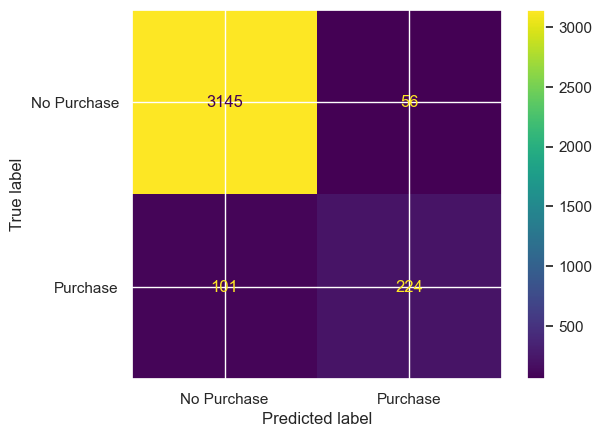

In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_test_array, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Purchase", "Purchase"])
disp.plot()
plt.show()


In [ ]:
#Classification Report
print("\n Classification Report (SVM):\n")
print(classification_report(y_test_array, y_pred_svm))



 Classification Report (SVM):

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3201
           1       0.80      0.69      0.74       325

    accuracy                           0.96      3526
   macro avg       0.88      0.84      0.86      3526
weighted avg       0.95      0.96      0.95      3526



Create a Comparison Table

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create a dictionary with metrics for each model
metrics = {
    'Model': ['Logistic Regression', 'KNN', 'SVM'],
    'Accuracy': [
        accuracy_score(y_test_array, y_pred_class),
        accuracy_score(y_test_array, y_pred_knn),
        accuracy_score(y_test_array, y_pred_svm)
    ],
    'Precision': [
        precision_score(y_test_array, y_pred_class),
        precision_score(y_test_array, y_pred_knn),
        precision_score(y_test_array, y_pred_svm)
    ],
    'Recall': [
        recall_score(y_test_array, y_pred_class),
        recall_score(y_test_array, y_pred_knn),
        recall_score(y_test_array, y_pred_svm)
    ],
    'F1-Score': [
        f1_score(y_test_array, y_pred_class),
        f1_score(y_test_array, y_pred_knn),
        f1_score(y_test_array, y_pred_svm)
    ]
}

# Convert to DataFrame
comparison_df = pd.DataFrame(metrics)
comparison_df


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.950085,0.822511,0.584615,0.683453
1,KNN,0.950369,0.790698,0.627692,0.699828
2,SVM,0.955474,0.800000,0.689231,0.740496


Visualize Comparison

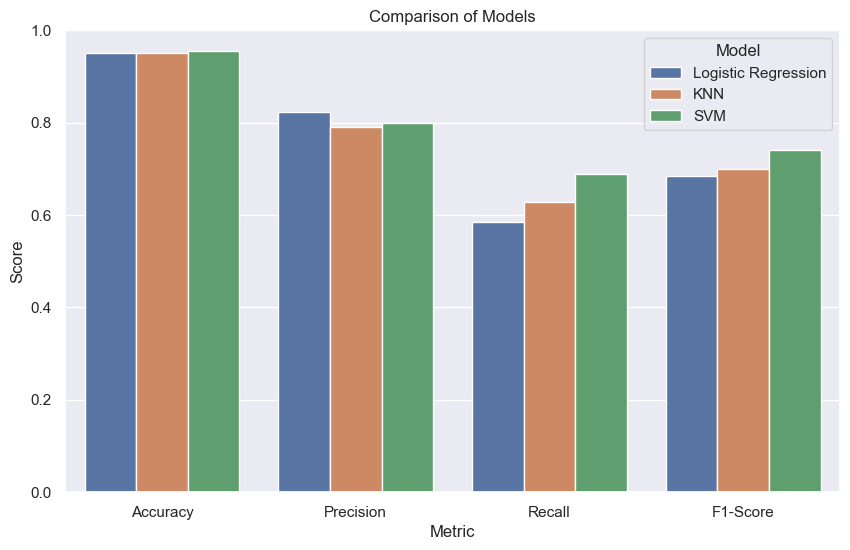

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt dataframe for plotting
df_melt = comparison_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(10,6))
sns.barplot(x='Metric', y='Score', hue='Model', data=df_melt)
plt.title('Comparison of Models')
plt.ylim(0,1)
plt.show()
